## Data Analysis
This notebook will be used to analyse data from Combination Lock experiments.

### Install Libraries

In [7]:
%%capture

%pip install matplotlib
import json
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl


### Read in Files

In [8]:
log_dir = './docs/evaluation-logs/*'
filepaths = glob.glob(log_dir)

files = []

for path in filepaths:
    with open(path) as f:
        files.append(json.load(f)['data'])

### Extract Data Across Participants into Single Dict

In [9]:
fullDict = {}


for f in files:
    fullDict = fullDict | f

print(len(fullDict))

42


### Traverse entire dataset, adding each list to the appropraite method list

In [10]:
methodsDict = {'tap6':[], 'tap10':[], 'direction6':[], 'direction10':[], 'pin':[],'pattern':[]}

for key in fullDict.keys():
    method = fullDict[key][0]['method']
    numTicks = fullDict[key][0]['numTicks']

    if method == 'tap':
        if numTicks == '6':
            methodsDict['tap6'] += fullDict[key]
        else:
            methodsDict['tap10'] += fullDict[key]
    elif  method == 'direction':
        if numTicks == '6':
            methodsDict['direction6'] += fullDict[key]
        else:
            methodsDict['direction10'] += fullDict[key]
    elif method == 'PATTERN':
        methodsDict['pattern'] += fullDict[key]
    elif method == 'PIN':
        methodsDict['pin'] += fullDict[key]
    
# Remove Abortions
for key in methodsDict:
    methodsDict[key] = list(filter(lambda x:x['endState'] != 'ABORTED', methodsDict[key]))

### Graph Average Success Rate For Each Method

<BarContainer object of 6 artists>

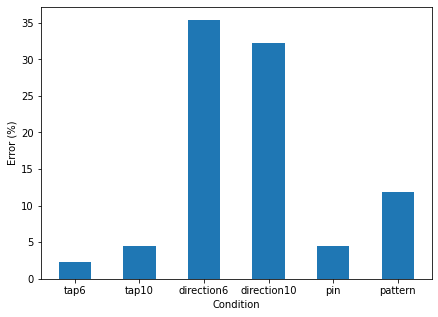

In [30]:
successRates = {}

def computeErrorRate(lst):
    errors = len(list(filter(lambda x: x['endState'] == 'FAILURE', lst)))
    return (errors / len(lst)) * 100

for method in methodsDict:
    successRates[method] = computeErrorRate(methodsDict[method])


fig, ax = plt.subplots(figsize=(7,5))
ax.set_ylabel('Error (%)')
ax.set_xlabel('Condition')

x = list(successRates.keys())
y = list(successRates.values())
ax.bar(x, y, 0.5)

### Graph Average Authentication Time for Successful Sessions

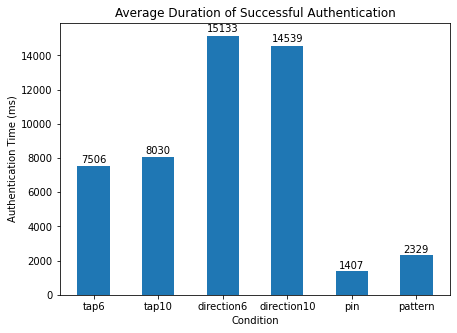

In [62]:
def computeAverageSuccessTime(lst):
    successfulAuths = list(filter(lambda x: x['endState']=='SUCCESS', lst))
    total = 0
    for val in lst:
        total+= val['elapsedTimeInMilliseconds']
    return total/len(successfulAuths)

for method in methodsDict:
    successRates[method] = computeAverageSuccessTime(methodsDict[method])

fig, ax = plt.subplots(figsize=(7,5))
ax.set_ylabel('Authentication Time (ms)')
ax.set_xlabel('Condition')
ax.set_title('Average Duration of Successful Authentication')

x = list(successRates.keys())
y = list(successRates.values())
rects = ax.bar(x, y, 0.5)

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, '%d' % int(height), ha='center', va='bottom')